# **Deep Neural Network for FashionMNIST dataset**

## **1 : Data and Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load the Fashion MNIST dataset
Observe that we set `shuffle=True`, which means that data is randomized

In [2]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

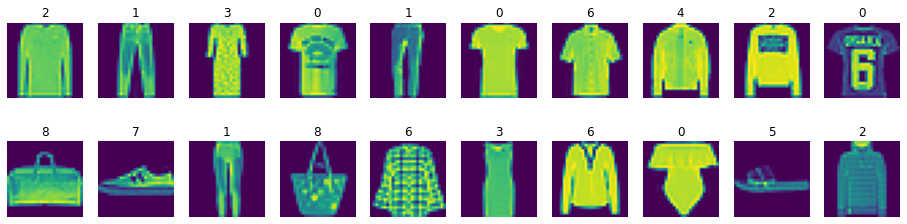

In [3]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [4]:
label_batch.unique() #10 classes in FashionMNIST dataset

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We have 10 different Classes in FashionMNIST dataset

## **2 : A 2-hidden layer Fully Connected Neural Network**


### Helper functions for training and testing

In [5]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### Defining the Fully Connected Network

In [6]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 200), 
            nn.ReLU(), 
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,60), 
            nn.ReLU(), 
            nn.Linear(60, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

### Train the Network

In [7]:
print("Training on ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5,)
print('Number of parameters: {}\n'.format(get_n_params(model_fnn)))

for epoch in range(0, 20):
    train(epoch, model_fnn)
    print('Epoch:',epoch)
    test(model_fnn)
    print('\n')

Training on  cuda:0
Number of parameters: 183770

Epoch: 0
Average loss: 0.5504, Accuracy: 8043/10000 (80%)


Epoch: 1
Average loss: 0.4594, Accuracy: 8368/10000 (84%)


Epoch: 2
Average loss: 0.4330, Accuracy: 8441/10000 (84%)


Epoch: 3
Average loss: 0.4005, Accuracy: 8515/10000 (85%)


Epoch: 4
Average loss: 0.4028, Accuracy: 8536/10000 (85%)


Epoch: 5
Average loss: 0.3941, Accuracy: 8548/10000 (85%)


Epoch: 6
Average loss: 0.3742, Accuracy: 8656/10000 (87%)


Epoch: 7
Average loss: 0.3870, Accuracy: 8621/10000 (86%)


Epoch: 8
Average loss: 0.3620, Accuracy: 8669/10000 (87%)


Epoch: 9
Average loss: 0.3561, Accuracy: 8723/10000 (87%)


Epoch: 10
Average loss: 0.3586, Accuracy: 8699/10000 (87%)


Epoch: 11
Average loss: 0.3544, Accuracy: 8719/10000 (87%)


Epoch: 12
Average loss: 0.3386, Accuracy: 8805/10000 (88%)


Epoch: 13
Average loss: 0.3382, Accuracy: 8800/10000 (88%)


Epoch: 14
Average loss: 0.3524, Accuracy: 8744/10000 (87%)


Epoch: 15
Average loss: 0.3526, Accuracy: 876

### Show some predictions of the test network

In [8]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(numpy.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

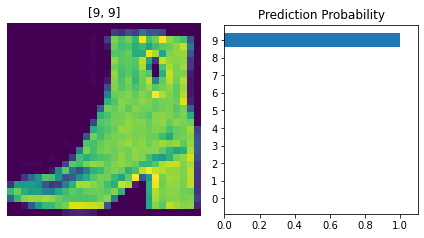

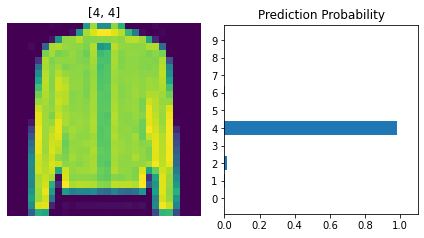

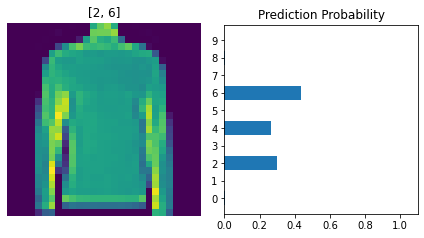

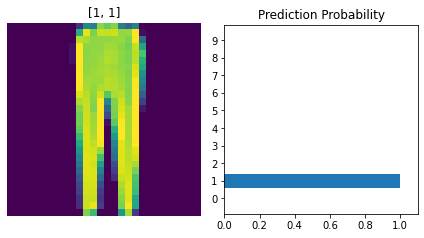

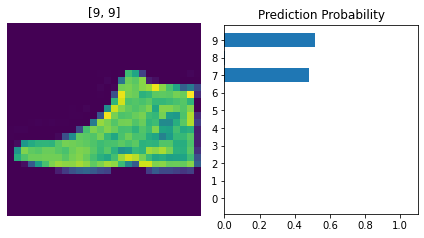

In [9]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(5):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## **3 : A 2-hidden layer Fully Connected Neural Network with Dropout**

### Defining the Fully Connected Network with Droupout

In [10]:
class FC2LayerDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2LayerDropout, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.Dropout(0.25),
            nn.ReLU(), 
            nn.Linear(200, 100),
            nn.Dropout(0.25),
            nn.ReLU(), 
            nn.Linear(100,60),
            nn.ReLU(),
            nn.Linear(60, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

### Train the Network

In [11]:
print("Training on ", device)
model = FC2LayerDropout(input_size, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}\n'.format(get_n_params(model)))

for epoch in range(0, 20):
    model.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model)
    print('Epoch:',epoch)
    model.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model)
    print('\n')

Training on  cuda:0
Number of parameters: 183770

Epoch: 0
Average loss: 0.5586, Accuracy: 7993/10000 (80%)


Epoch: 1
Average loss: 0.4589, Accuracy: 8303/10000 (83%)


Epoch: 2
Average loss: 0.4203, Accuracy: 8477/10000 (85%)


Epoch: 3
Average loss: 0.4149, Accuracy: 8489/10000 (85%)


Epoch: 4
Average loss: 0.3941, Accuracy: 8587/10000 (86%)


Epoch: 5
Average loss: 0.3913, Accuracy: 8566/10000 (86%)


Epoch: 6
Average loss: 0.3736, Accuracy: 8656/10000 (87%)


Epoch: 7
Average loss: 0.3633, Accuracy: 8710/10000 (87%)


Epoch: 8
Average loss: 0.3551, Accuracy: 8734/10000 (87%)


Epoch: 9
Average loss: 0.3504, Accuracy: 8738/10000 (87%)


Epoch: 10
Average loss: 0.3417, Accuracy: 8753/10000 (88%)


Epoch: 11
Average loss: 0.3402, Accuracy: 8752/10000 (88%)


Epoch: 12
Average loss: 0.3414, Accuracy: 8759/10000 (88%)


Epoch: 13
Average loss: 0.3397, Accuracy: 8763/10000 (88%)


Epoch: 14
Average loss: 0.3308, Accuracy: 8809/10000 (88%)


Epoch: 15
Average loss: 0.3339, Accuracy: 879

### Show some predictions of the test network

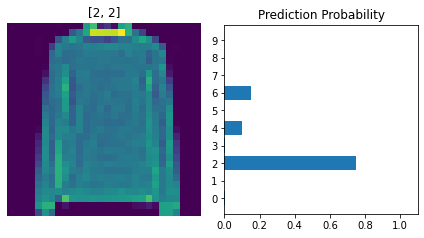

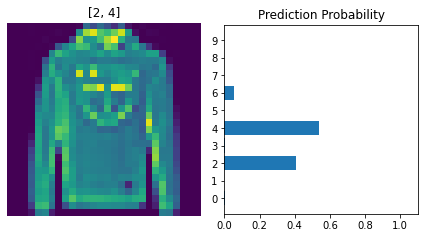

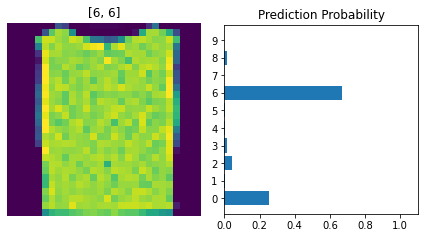

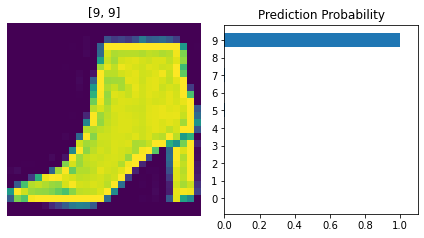

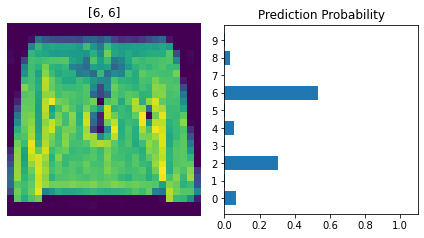

In [12]:
model.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model(image_batch)
for i in range(5):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## **4 : Does the Fully Connected Network use "Visual Information" ?**

### Making permutations (Scramble) of dataset to create new point with no visual information

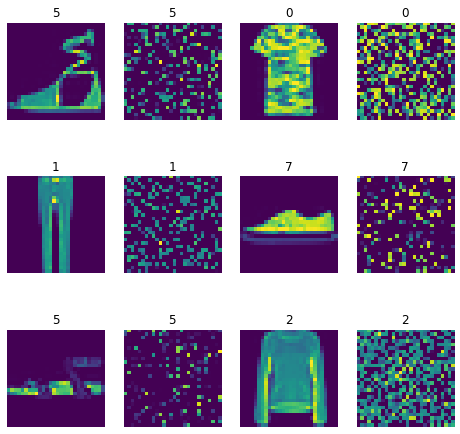

In [13]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

We can see that the permutated data point does not contain any visual information. Now we will use these new point to answer our question.

### Helper function for Scramble images.

In [14]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
            
def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### Train the Network

In [15]:
print("Training on ", device)
model_fnn_2 = FC2Layer(input_size, output_size)
model_fnn_2.to(device)
optimizer = optim.SGD(model_fnn_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}\n'.format(get_n_params(model_fnn_2)))

for epoch in range(0, 20):
    scramble_train(epoch, model_fnn_2, fixed_perm)
    print('Epoch:',epoch)
    scramble_test(model_fnn_2, fixed_perm)
    print('\n')

Training on  cuda:0
Number of parameters: 183770

Epoch: 0
Average loss: 0.5953, Accuracy: 7799/10000 (78%)


Epoch: 1
Average loss: 0.4577, Accuracy: 8380/10000 (84%)


Epoch: 2
Average loss: 0.4179, Accuracy: 8498/10000 (85%)


Epoch: 3
Average loss: 0.4190, Accuracy: 8515/10000 (85%)


Epoch: 4
Average loss: 0.3828, Accuracy: 8602/10000 (86%)


Epoch: 5
Average loss: 0.3713, Accuracy: 8664/10000 (87%)


Epoch: 6
Average loss: 0.3619, Accuracy: 8699/10000 (87%)


Epoch: 7
Average loss: 0.3797, Accuracy: 8567/10000 (86%)


Epoch: 8
Average loss: 0.3733, Accuracy: 8640/10000 (86%)


Epoch: 9
Average loss: 0.3425, Accuracy: 8760/10000 (88%)


Epoch: 10
Average loss: 0.3488, Accuracy: 8767/10000 (88%)


Epoch: 11
Average loss: 0.3598, Accuracy: 8719/10000 (87%)


Epoch: 12
Average loss: 0.3703, Accuracy: 8699/10000 (87%)


Epoch: 13
Average loss: 0.3394, Accuracy: 8783/10000 (88%)


Epoch: 14
Average loss: 0.3461, Accuracy: 8768/10000 (88%)


Epoch: 15
Average loss: 0.3400, Accuracy: 880

 Model still is giving good accuracy on Scramble images, So DNNs doesn't use visual information.

### Show some predictions of the test network

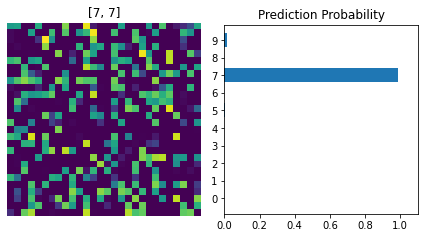

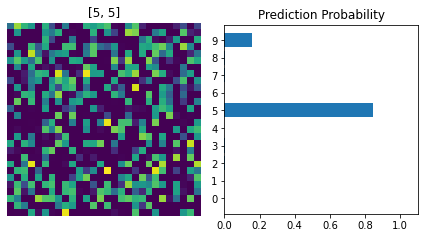

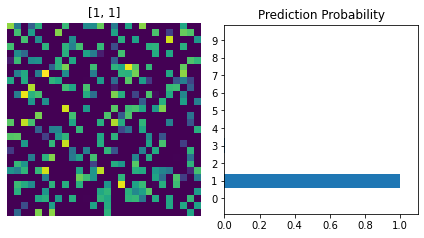

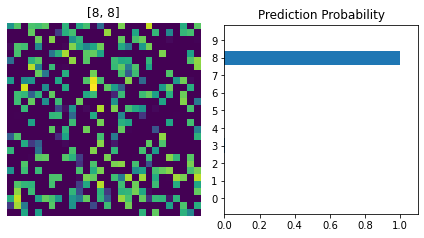

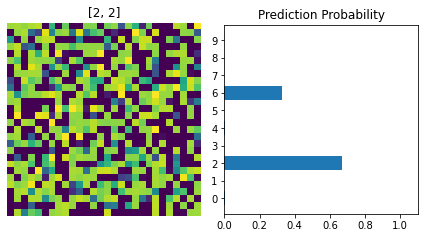

In [16]:
model_fnn_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn_2(image_batch_scramble)
for i in range(5):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)

# **Convolutional Neural Network for FashionMNIST dataset**

## **1 : A Convolutional Neural Network**

### Helper functions for training and testing
Same as in DNN model

### Defining a Convolutional Neural Network


In [17]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Train the Network

In [18]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}\n'.format(get_n_params(model_cnn)))

for epoch in range(0, 20):
    train(epoch, model_cnn)
    print('Epoch:',epoch)
    test(model_cnn)
    print('\n')

Training on  cuda:0
Number of parameters: 66002

Epoch: 0
Average loss: 0.6899, Accuracy: 7382/10000 (74%)


Epoch: 1
Average loss: 0.5276, Accuracy: 8036/10000 (80%)


Epoch: 2
Average loss: 0.4816, Accuracy: 8213/10000 (82%)


Epoch: 3
Average loss: 0.4179, Accuracy: 8488/10000 (85%)


Epoch: 4
Average loss: 0.4166, Accuracy: 8490/10000 (85%)


Epoch: 5
Average loss: 0.3777, Accuracy: 8645/10000 (86%)


Epoch: 6
Average loss: 0.3927, Accuracy: 8530/10000 (85%)


Epoch: 7
Average loss: 0.3773, Accuracy: 8676/10000 (87%)


Epoch: 8
Average loss: 0.3476, Accuracy: 8675/10000 (87%)


Epoch: 9
Average loss: 0.3381, Accuracy: 8771/10000 (88%)


Epoch: 10
Average loss: 0.3610, Accuracy: 8693/10000 (87%)


Epoch: 11
Average loss: 0.3236, Accuracy: 8830/10000 (88%)


Epoch: 12
Average loss: 0.3108, Accuracy: 8882/10000 (89%)


Epoch: 13
Average loss: 0.3104, Accuracy: 8918/10000 (89%)


Epoch: 14
Average loss: 0.3106, Accuracy: 8889/10000 (89%)


Epoch: 15
Average loss: 0.3047, Accuracy: 8909

### Show some predictions of the test network

In [19]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(numpy.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

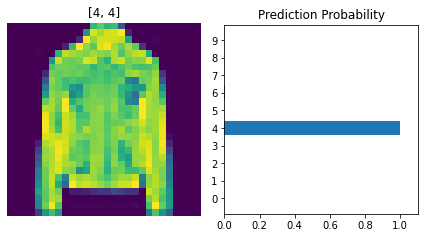

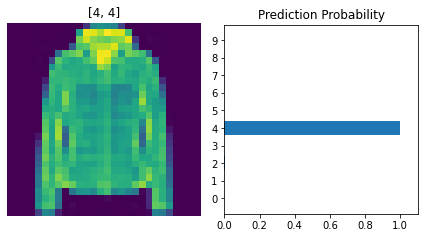

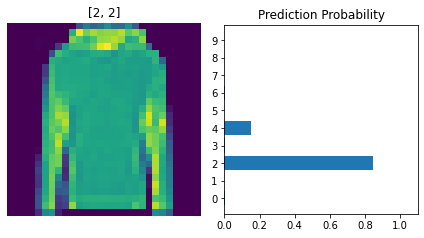

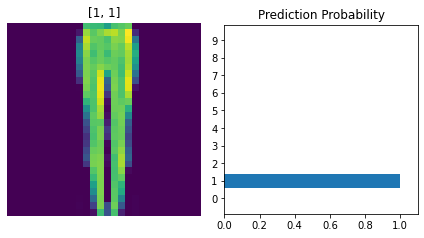

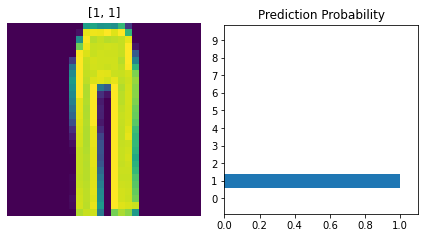

In [20]:
model_cnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)
for i in range(5):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## **2 : A Convolutional Neural Network with dropout**

### Defining a Convolutional Neural Network with dropout


In [21]:
class CNNDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.do1 = nn.Dropout2d(p=0.8)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = self.do1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Train the Network

In [22]:
print("Training on ", device)
model_2 = CNNDropout(input_size, output_size)
model_2.to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}\n'.format(get_n_params(model_2)))

for epoch in range(0, 20):
    model_2.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model_2)
    print('Epoch:',epoch)
    model_2.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model_2)
    print('\n')

Training on  cuda:0
Number of parameters: 66002

Epoch: 0
Average loss: 0.6458, Accuracy: 7543/10000 (75%)


Epoch: 1
Average loss: 0.5553, Accuracy: 7893/10000 (79%)


Epoch: 2
Average loss: 0.5104, Accuracy: 8031/10000 (80%)


Epoch: 3
Average loss: 0.4771, Accuracy: 8187/10000 (82%)


Epoch: 4
Average loss: 0.4438, Accuracy: 8278/10000 (83%)


Epoch: 5
Average loss: 0.5289, Accuracy: 8055/10000 (81%)


Epoch: 6
Average loss: 0.3929, Accuracy: 8524/10000 (85%)


Epoch: 7
Average loss: 0.3990, Accuracy: 8451/10000 (85%)


Epoch: 8
Average loss: 0.3762, Accuracy: 8571/10000 (86%)


Epoch: 9
Average loss: 0.3654, Accuracy: 8614/10000 (86%)


Epoch: 10
Average loss: 0.3573, Accuracy: 8682/10000 (87%)


Epoch: 11
Average loss: 0.3378, Accuracy: 8742/10000 (87%)


Epoch: 12
Average loss: 0.3389, Accuracy: 8734/10000 (87%)


Epoch: 13
Average loss: 0.3372, Accuracy: 8765/10000 (88%)


Epoch: 14
Average loss: 0.3286, Accuracy: 8797/10000 (88%)


Epoch: 15
Average loss: 0.3160, Accuracy: 8824

### Show some predictions of the test network

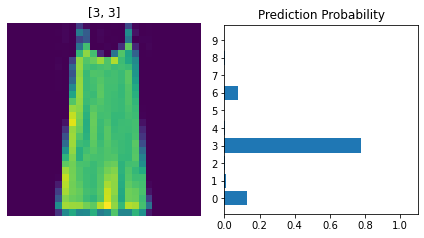

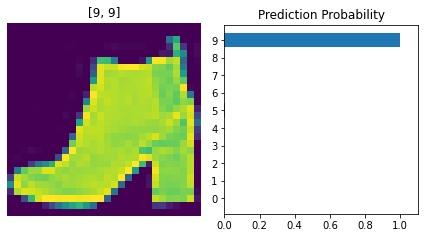

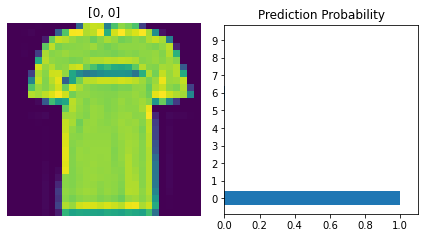

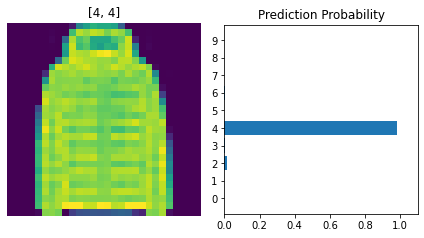

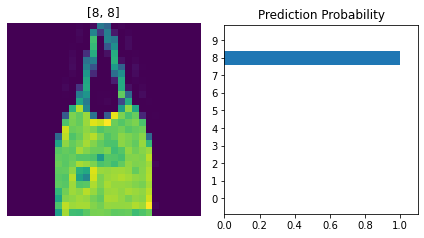

In [23]:
model_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_2(image_batch)
for i in range(5):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## **3 : Does the Convolutional Neural Network use "Visual Information" ?**

### Making permutations (Scramble) of dataset to create new point with no visual information

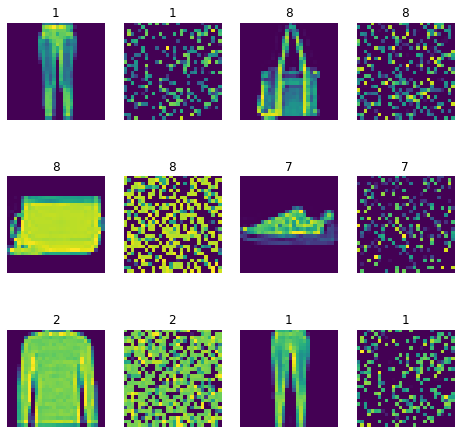

In [24]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)


### Helper function for Scramble images.
Same as in DNN model

### Train the Network

In [25]:
print("Training on ", device)
model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}\n'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 20):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    print('Epoch:',epoch)
    scramble_test(model_cnn_3, fixed_perm)
    print('\n')

Training on  cuda:0
Number of parameters: 66002

Epoch: 0
Average loss: 0.5763, Accuracy: 7969/10000 (80%)


Epoch: 1
Average loss: 0.4635, Accuracy: 8345/10000 (83%)


Epoch: 2
Average loss: 0.4256, Accuracy: 8474/10000 (85%)


Epoch: 3
Average loss: 0.4213, Accuracy: 8485/10000 (85%)


Epoch: 4
Average loss: 0.4080, Accuracy: 8500/10000 (85%)


Epoch: 5
Average loss: 0.3759, Accuracy: 8652/10000 (87%)


Epoch: 6
Average loss: 0.3552, Accuracy: 8724/10000 (87%)


Epoch: 7
Average loss: 0.3564, Accuracy: 8699/10000 (87%)


Epoch: 8
Average loss: 0.3735, Accuracy: 8641/10000 (86%)


Epoch: 9
Average loss: 0.3863, Accuracy: 8663/10000 (87%)


Epoch: 10
Average loss: 0.3740, Accuracy: 8677/10000 (87%)


Epoch: 11
Average loss: 0.3708, Accuracy: 8714/10000 (87%)


Epoch: 12
Average loss: 0.3753, Accuracy: 8710/10000 (87%)


Epoch: 13
Average loss: 0.3855, Accuracy: 8690/10000 (87%)


Epoch: 14
Average loss: 0.3942, Accuracy: 8697/10000 (87%)


Epoch: 15
Average loss: 0.3973, Accuracy: 8717

Model's accuracy is decreased by 3%, So CNNs uses visual information.

### Show some predictions of the test network

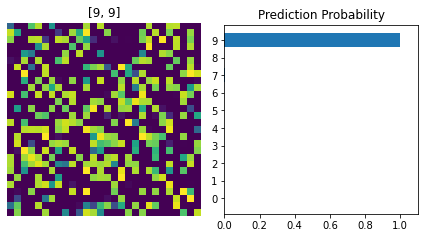

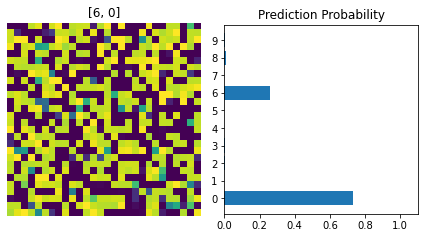

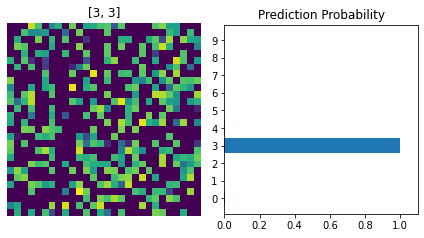

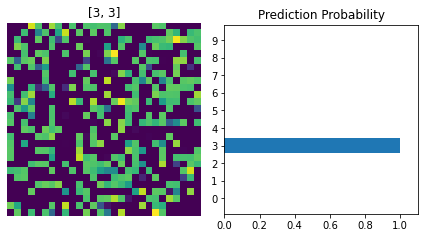

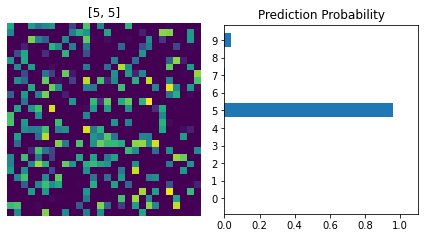

In [26]:
model_cnn_3.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)
for i in range(5):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)

# Observations:
|Model | Dropout | Scrambled | Accuracy (%)|
|------|---------|-----------|---------|
|DNN|No|No|89|
|DNN|Yes|No|88|
|DNN|No|Yes|88|
|CNN|No|No|89|
|CNN|Yes|No|89|
|CNN|No|Yes|86| 

# Conclusions: 
DNN and CNN are giving similar accuracies. But in case of Scrambled data DNN is still classifying currectly while CNN is misclassifying these points.

So, Only CNN uses visual information.